In [1]:
# no tracking server
# local backend and artifact store

import mlflow
import pandas as pd
import os
import numpy as np
import torch
from fastai.vision.all import *
import random
from torchvision.models import resnet50, ResNet50_Weights

In [2]:
def seed_everything(seed=0):
    """ ensure reproducability by defining random seed """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

In [3]:
os.environ['TORCH_HOME'] = 'models\\resnet' #setting the environment variable
path = os.path.join(os.getcwd(), 'data')  # path to downloaded dataset

In [4]:
print(f"local tracking uri {mlflow.get_tracking_uri()}")
mlflow.list_experiments()

local tracking uri file:///home/xydo/mlops_zoomcamp_homework/06_project/mlruns


[<Experiment: artifact_location='file:///home/xydo/mlops_zoomcamp_homework/06_project/mlruns/0', experiment_id='0', lifecycle_stage='active', name='Default', tags={}>]

In [13]:
def preprocess_data(df, metadata):
    """ add label column and change path to fname column"""
    df_lego = pd.merge(df, metadata['minifigure_name'], on='class_id')
    df_lego['labels'] = df_lego['minifigure_name'].apply(lambda x: x.lower())
    df_lego['fname'] = df_lego['path']
    return df_lego

In [15]:
def print_auto_logged_info(r):
    tags = {k: v for k, v in r.data.tags.items() if not k.startswith("mlflow.")}
    artifacts = [f.path for f in MlflowClient().list_artifacts(r.info.run_id, "model")]
    print("run_id: {}".format(r.info.run_id))
    print("artifacts: {}".format(artifacts))
    print("params: {}".format(r.data.params))
    print("metrics: {}".format(r.data.metrics))
    print("tags: {}".format(tags))

# first experiment

/home/xydo/.virtualenvs/mlops_zoomcamp_homework-Pekz4x7C/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/xydo/.virtualenvs/mlops_zoomcamp_homework-Pekz4x7C/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.726962,2.585535,0.702703,0.297297,04:41
1,2.019013,1.806373,0.405405,0.594595,04:49
2,1.134601,1.549646,0.459459,0.540541,05:01
3,0.732874,0.920175,0.351351,0.648649,05:17
4,0.573818,1.324280,0.297297,0.702703,04:43
5,0.632161,0.989384,0.162162,0.837838,04:30


Better model found at epoch 0 with valid_loss value: 2.5855345726013184.


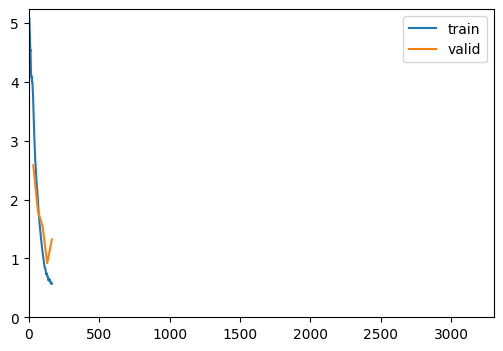

Better model found at epoch 1 with valid_loss value: 1.8063730001449585.
Better model found at epoch 2 with valid_loss value: 1.5496456623077393.
Better model found at epoch 3 with valid_loss value: 0.9201753735542297.
Epoch 4: reducing lr to 0.0013060028959062395
Epoch 5: reducing lr to 0.0016884635482598974
No improvement since epoch 3: early stopping


In [18]:
mlflow.set_experiment("project_resnet50_first")


mlflow.fastai.autolog()
    
with mlflow.start_run():
    df = pd.read_csv(os.path.join(path, 'index.csv'), index_col=1)
    lego_metadata = pd.read_csv(os.path.join(path, 'metadata.csv'), index_col=0)
    df_lego = preprocess_data(df, lego_metadata)
    data = ImageDataLoaders.from_df(df_lego, path, valid_pct=0.10,
                                   item_tfms=Resize(412),
                                   bs=10, num_workers=0, label_col="labels")
    resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
    learn = vision_learner(data, resnet50, metrics=[error_rate, accuracy], model_dir = Path(os.path.join(os.getcwd(),
                                                                                                   "models",
                                                                                                      "resnet")),
                       path =Path(""
                                                                                                                    "."))
    params = {"lr1": 1e-3, "lr2": 1e-1, "random_seed": 0}
    mlflow.log_params(params)
    learn.fit_one_cycle(100, slice(params["lr1"],params["lr2"]),cbs=[EarlyStoppingCallback(patience=2),
                                                                    ShowGraphCallback(),
                                                SaveModelCallback(fname='model_best'),ReduceLROnPlateau()])

In [19]:
# check if best model was stored
best_model_path = Path.cwd()'/models/resnet/model_best.pth'
assert (best_model_path).exists()

SyntaxError: invalid syntax (2188668768.py, line 2)

# load best model

In [ ]:
learn = vision_learner(data, resnet50, metrics=[error_rate, accuracy], model_dir = Path(os.path.join(os.getcwd(),
                                                                                                   "models",
                                                                                                      "resnet")),
                       path =Path(""
                                                                                                                    "."))
learn.load(best_model_path)